#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

#from bvcopula import SingleParamCopulaBase
from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula, StudentTCopula_Likelihood
from bvcopula import MixtureCopula, MixtureCopula_Likelihood
from bvcopula import GPInferenceModel, KISS_GPInferenceModel
from bvcopula import Mixed_GPInferenceModel, GridInterpolationVariationalStrategy

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#here we specify a 'true' latent function lambda
theta1 = lambda x: np.cos(2*np.pi*3*x)*4.+5. #*np.sin(2*np.pi*3*x+.6)
theta2 = lambda x: np.sin(2*np.pi*3*x)*4.+5. #*np.sin(2*np.pi*3*x+.6)
con = lambda x: np.cos(2*np.pi*1*x)*0.5+0.5 #*np.sin(2*np.pi*3*x+.6)

(1000, 2)


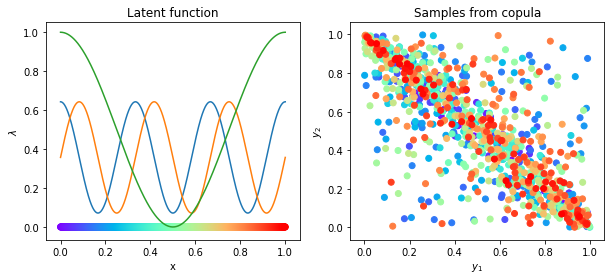

In [3]:
# here we generate some synthetic samples
import matplotlib.cm as cm

NSamp = int(1e3)

X = np.linspace(0.,1.,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

lambdaf.plot(X,theta1(X)/14.)
lambdaf.plot(X,theta2(X)/14.)
lambdaf.plot(X,con(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

theta = torch.stack([torch.tensor([theta1(x) for x in X]),
                     torch.tensor([theta2(x) for x in X])]).float()
mix = torch.stack([torch.tensor([con(x) for x in X]),
                   torch.tensor([1-con(x) for x in X])]).float()
#likelihoods = [GaussianCopula_Likelihood(),FrankCopula_Likelihood()]
likelihoods = [GumbelCopula_Likelihood(rotation='270°'),GumbelCopula_Likelihood(rotation='90°')]
copulas = [lik.copula for lik in likelihoods]
rotations = [lik.rotation for lik in likelihoods]
model = MixtureCopula(theta,mix,copulas,rotations=rotations)
Y = model.sample().numpy().squeeze()
print(Y.shape)
colors = cm.rainbow(np.linspace(0., 1., NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from copula')

fig.show()

In [4]:
Y[Y!=Y]

array([], dtype=float32)

In [5]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)

In [6]:
# define the model (optionally on GPU)
grid_size = 128#train_x.shape[0]
model = Mixed_GPInferenceModel(MixtureCopula_Likelihood(likelihoods), 2*len(likelihoods)-1, \
                               prior_rbf_length=0.2, grid_size=grid_size).cuda(device=0)

In [7]:
# train the model

base_lr = 1e-4
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.variational_distribution.chol_variational_covar},
    {'params': model.covar_module.raw_outputscale},
    {'params': model.variational_strategy.variational_distribution.variational_mean, 'lr': .1},
    {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': .01} #, 'lr': 0.001
], lr=base_lr)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll  = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=True)
#mllv = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=False)

losses, rbf, means = [], [], []

def train(train_x, train_y, num_iter=2000):
    model.train()

    p = 0.
    nans = 0
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)  
        #log_lik, kl_div, log_prior = mllv(output, train_y)
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss.detach().cpu().numpy())
        rbf.append(model.covar_module.base_kernel.lengthscale.detach().cpu().numpy())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy())
        if not (i + 1) % iter_print:
            
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {}, dLoss: {:.3}, mean f: {:.3}, dmean: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().squeeze(), 
                mean_p, np.mean(means[-1]), 
                np.mean(np.abs(means[-100]-means[-1]))
            ))
            #print("{:.3}, {:.3}, {:.3}".format(log_lik, kl_div, log_prior))

            #print(np.std(losses[-100:]))
            if (0 < mean_p < 0.001):# & (np.mean(np.abs(1-means[-100]/means[-1])) < 0.05): 
                print("Converged!")
                break
            p = 0.

        # The actual optimization step

        loss.backward()
#         for par in model.parameters():
#             grad = par.grad.data
#             if torch.nonzero(grad!=grad).shape[0]!=0:
#                 print('NaN grad')
#             nans+=torch.nonzero(grad!=grad).shape[0]
#             if torch.any(grad.abs()==float('inf')):
#                 print("Grad inf... fixing...")
#                 grad = torch.clamp(grad,-1.,1.)
#             grad[grad!=grad] = 0.0
#             par.grad.data = grad
        covar_grad = model.variational_strategy.variational_distribution.chol_variational_covar.grad
        assert torch.all(covar_grad==covar_grad)
        optimizer.step()
        
%time train(train_x,train_y)

Basic lr for most of parameters: 0.0001
Nan


AssertionError: 

(1, 3, 128)


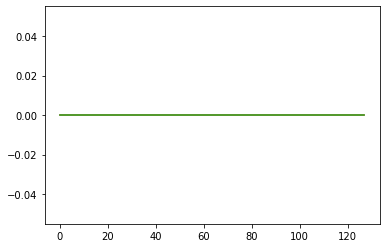

In [8]:
print(np.shape(means))
plt.plot(means[-1][0])
plt.plot(means[-1][1])
plt.plot(means[-1][2])
losses[losses!=losses] = 0

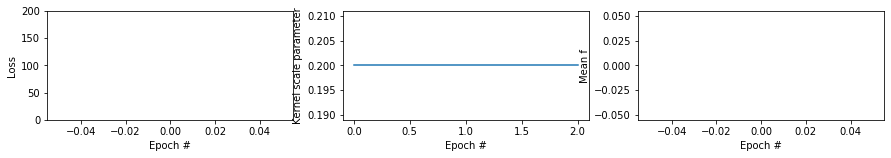

In [9]:
# prot loss function and kernel length
fig, (loss, kern, mean) = plt.subplots(1,3,figsize=(15,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
loss.set_ylim(np.min(losses)*1.1,200)
rbf=np.array(rbf).squeeze()
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x,axis=1) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

In [10]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

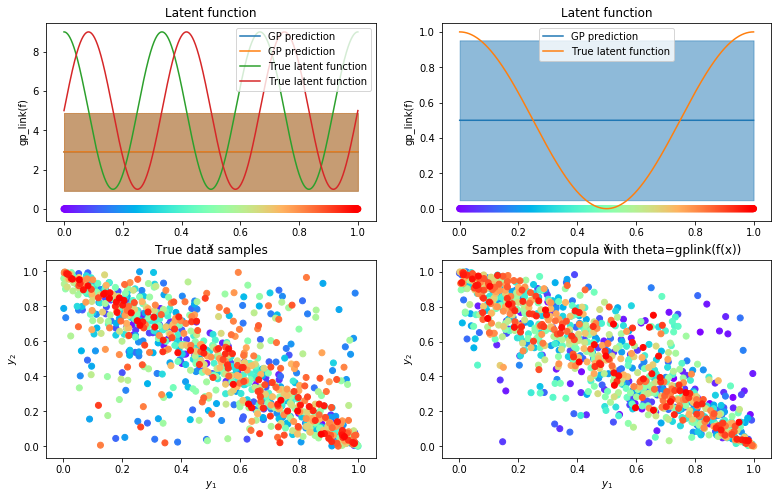

In [11]:
# visualize the result
fig, ax = plt.subplots(2,2,figsize=(13, 8))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function

thetas, mixes = gplink(output.mean)
lower, upper = output.confidence_region() #thetas & mix together
thetas_low, mixes_low = gplink(lower)
thetas_upp, mixes_upp = gplink(upper)
 
for t,l,u in zip(thetas,thetas_low,thetas_upp):
    F_mean = t.detach().cpu().numpy()
    line, = ax[0,0].plot(testX, F_mean, label = 'GP prediction')
    ax[0,0].fill_between(testX, l.detach().cpu().numpy(),
                    u.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

ax[0,0].plot(testX,theta1(testX), label = 'True latent function')
ax[0,0].plot(testX,theta2(testX), label = 'True latent function')
ax[0,0].scatter(X,np.zeros_like(X),color=colors)
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('gp_link(f)')
ax[0,0].set_title('Latent function')
ax[0,0].legend()

for t,l,u in zip(mixes[:-1],mixes_low[:-1],mixes_upp[:-1]):
    F_mean = t.detach().cpu().numpy()
    line, = ax[0,1].plot(testX, F_mean, label = 'GP prediction')
    ax[0,1].fill_between(testX, l.detach().cpu().numpy(),
                    u.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

ax[0,1].plot(testX,con(testX), label = 'True latent function')
ax[0,1].scatter(X,np.zeros_like(X),color=colors)
ax[0,1].set_xlabel('x')
ax[0,1].set_ylabel('gp_link(f)')
ax[0,1].set_title('Latent function')
ax[0,1].legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
skip = 1
ax[1,0].scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
ax[1,1].scatter(*Y_sim[:,:,::skip].T, label = 'Sample from the model', color=colors[::skip])
for c in [0,1]:
    ax[1,c].set_xlabel('$y_1$')
    ax[1,c].set_ylabel('$y_2$')
ax[1,0].set_title('True data samples')
ax[1,1].set_title('Samples from copula with theta=gplink(f(x))')
# samp.legend()



fig.show()